## Context

The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.

## Inspiration
Is it possible to make forecasts for thousands of products (some of them are highly variable in terms of monthly demand) for the the month after next?

## Questions
1. What is the demand change by SKU day by day?
2. Who is the average top demand product?
3. Which cateogory sells the best?
4. What is the average capacity for each warehouse?
5. Which warehouse carry the most SKUs?
6. What the volumne trend by SKUs?
7. Which SKU is the best seller?
8. Should I drop the missing data?

## Insights
1. There are 33 categories, 2160 SKUs, and 4 warehouses
2. We have missing dates of 11239
3. There are 1048575 rows of data

## Goal
Since the average lead time takes 30 days from sourcing to warehouses, we are going to predict the next 30 days demand by warehouse by sku to help the company in a good inventory shape

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
df = pd.read_csv("Historical Product Demand.csv", parse_dates=["Date"])
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016-04-27,1000
1048571,Product_1974,Whse_J,Category_006,2016-04-27,1
1048572,Product_1787,Whse_J,Category_006,2016-04-28,2500
1048573,Product_0901,Whse_J,Category_023,2016-10-07,50


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1048575 non-null  object        
 1   Warehouse         1048575 non-null  object        
 2   Product_Category  1048575 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1048575 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 40.0+ MB


In [9]:
df.isna().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [20]:
# 33 Categories
df.Product_Category.unique(), df.Product_Category.nunique()

(array(['Category_028', 'Category_006', 'Category_001', 'Category_019',
        'Category_005', 'Category_030', 'Category_032', 'Category_011',
        'Category_033', 'Category_007', 'Category_015', 'Category_021',
        'Category_024', 'Category_026', 'Category_023', 'Category_022',
        'Category_009', 'Category_003', 'Category_004', 'Category_018',
        'Category_020', 'Category_013', 'Category_008', 'Category_017',
        'Category_031', 'Category_025', 'Category_010', 'Category_029',
        'Category_012', 'Category_002', 'Category_014', 'Category_027',
        'Category_016'], dtype=object),
 33)

In [22]:
# 2160 SKUs
df.Product_Code.unique(), df.Product_Code.nunique()

(array(['Product_0993', 'Product_0979', 'Product_1159', ...,
        'Product_0237', 'Product_0644', 'Product_0853'], dtype=object),
 2160)

In [21]:
# 4 warehouses
df.Warehouse.unique(), df.Warehouse.nunique()

(array(['Whse_J', 'Whse_S', 'Whse_C', 'Whse_A'], dtype=object), 4)

In [10]:
df.Date[:1000]

0     2012-07-27
1     2012-01-19
2     2012-02-03
3     2012-02-09
4     2012-03-02
         ...    
995   2012-09-28
996   2012-12-12
997   2012-01-31
998   2012-03-02
999   2012-03-02
Name: Date, Length: 1000, dtype: datetime64[ns]

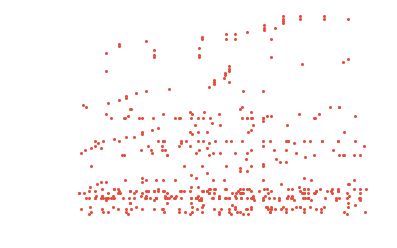

In [14]:
fig, ax = plt.subplots()
ax.scatter(df['Date'][:500],df['Order_Demand'][:500]);

In [94]:
# Sort Date by ASC
df.sort_values(by=["Date"], inplace=True, ascending=True)
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011-01-08,2
72252,Product_1724,Whse_A,Category_003,2011-05-31,108
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250
...,...,...,...,...,...
995790,Product_1464,Whse_A,Category_019,NaT,(900)
995791,Product_1541,Whse_A,Category_019,NaT,(200)
995792,Product_1388,Whse_A,Category_019,NaT,(300)
995793,Product_1541,Whse_A,Category_019,NaT,(300)


In [104]:
# df.Order_Demand = df.Order_Demand.replace('(',"-").replace(')',"")
df.Order_Demand = df.Order_Demand.str.replace('(','')
df.Order_Demand = df.Order_Demand.str.replace(')','')
df.Order_Demand = df.Order_Demand.astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 44799 to 995794
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1048575 non-null  object        
 1   Warehouse         1048575 non-null  object        
 2   Product_Category  1048575 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1048575 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 48.0+ MB


In [75]:
# What is missing?
df_na = df[df.Date.isnull()]
df_na.Product_Code.nunique(), df_na.Warehouse.unique()
# It looks like we have trouble on Warehouse A for the records
# Let's check how many total rows for Warehouse A

(82, array(['Whse_A'], dtype=object))

In [76]:
# The total record of Warehouse A is 153574
df[df.Warehouse=='Whse_A'].count()

# Should we drop the data without dates?
# What percentage of total data would impact

Product_Code        153574
Warehouse           153574
Product_Category    153574
Date                142335
Order_Demand        153574
dtype: int64

## Drop NA date

In [105]:

df_tmp = df.copy()
df_tmp = df_tmp.dropna()
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 44799 to 908844
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1037336 non-null  object        
 1   Warehouse         1037336 non-null  object        
 2   Product_Category  1037336 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1037336 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 47.5+ MB


In [106]:
df_tmp

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011-01-08,2
72252,Product_1724,Whse_A,Category_003,2011-05-31,108
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250
...,...,...,...,...,...
919651,Product_1926,Whse_J,Category_001,2017-01-06,2
920149,Product_0025,Whse_J,Category_005,2017-01-06,400
863020,Product_1904,Whse_C,Category_019,2017-01-09,4000
908447,Product_0250,Whse_C,Category_007,2017-01-09,148


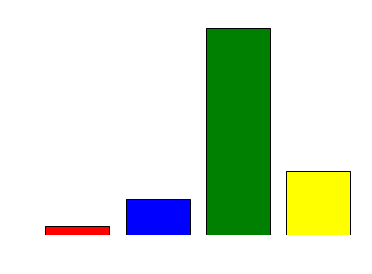

In [118]:
df_tmp_warehouse = df_tmp.groupby('Warehouse').sum().reset_index()
fig, ax = plt.subplots()
ax.bar(df_tmp_warehouse["Warehouse"], df_tmp_warehouse["Order_Demand"], label="Order_Demand",
      edgecolor="k", color=["red","blue","green","yellow"]);
ax.set_xlabel("Warehouse");
ax.set_xticks(df_tmp_warehouse["Warehouse"]);